In [2]:
#imports go here

from sage.plot.polygon import Polygon
from sage.plot.colors import rainbow

In [3]:
def add_points (a, b):
    return

# Note: This returns a graphics object. To get the actual polygon object, you must index into the return value at [0].
def construct_chair_primitive_tile (origin, orientation, color) -> Polygon:
    primitive_points = [(0,0), (2,0), (2,1), (1,1), (1,2), (0,2)]
    tile = polygon([( origin[0] + orientation[0] * p[0], origin[1] + orientation[1] * p[1]) for p in primitive_points], 
                   rgbcolor=color, edgecolor='black', fill=true)
    return tile

# To show the individual subtiles, we need to plot them each, so we need one graphics polygon that has a list of 
# each of the primitive tiles. To know the scale of the next supertile, we only need to keep track of that 
# tile's size. So, to make an L_n supertile, we take in 
# 1) the size of the tile
# 2) the origin of the tile (i.e. which corner is oppposite the missing chunk)
# 3) the orientation of the tile (given as a tuple of (+/- 1, +/- 1))
def construct_chair_supertile (size, origin, orientation, color) -> Polygon:
    #Now, we can start to construct the supertile. We want to combine four of the L_(n-1) tile.    
    if (size < 2):
        print(f"Invalid input size of {size}.")
        return
    if (size == 2):
        # This is our base case. We have a primitive tile, and we need to just plot it.
        return construct_chair_primitive_tile (origin, orientation, color)

    g = Graphics()

    #We have a supertile with n>0. This means we must use recursion to plot the tile.
    newsize = size // 2

    g += construct_chair_supertile (newsize, origin, orientation, color)
    g += construct_chair_supertile (newsize,
                                (origin[0] + orientation[0] * newsize / 2, origin[1] + orientation[1] * newsize / 2),
                                orientation,
                                color)
    g += construct_chair_supertile (newsize,
                                (origin[0] + orientation[0] * size, origin[1]),
                                (-1 * orientation[0], orientation[1]),
                                color)
    g += construct_chair_supertile (newsize,
                                (origin[0], origin[1] + orientation[1] * size),
                                (orientation[0], -1 * orientation[1]),
                                color)
    return g


def construct_chair_tiling (iterations):
    # rbow = rainbow(iterations)
    
    for i in range (iterations):
        g = construct_chair_supertile (2 ** (1+i), (0,0), (1,1), 'white')
        show(g, figsize=8)

    return

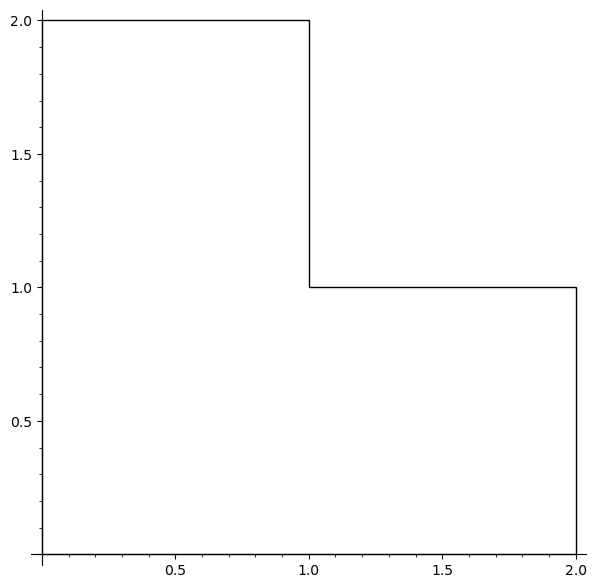

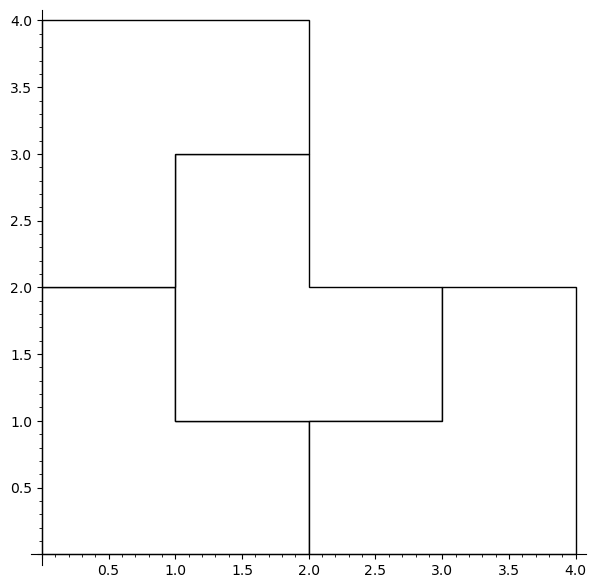

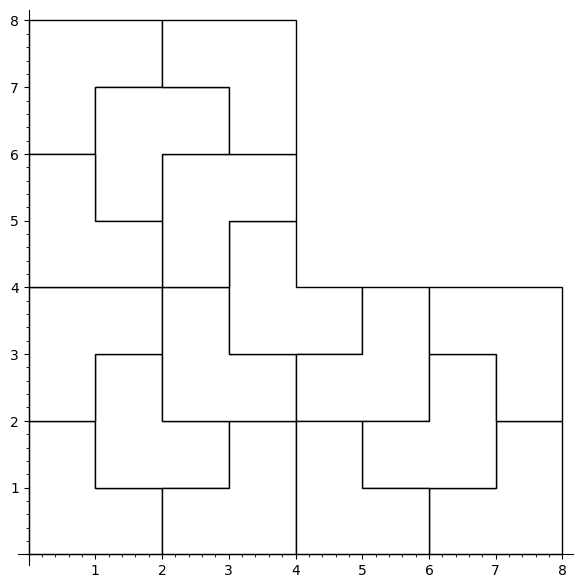

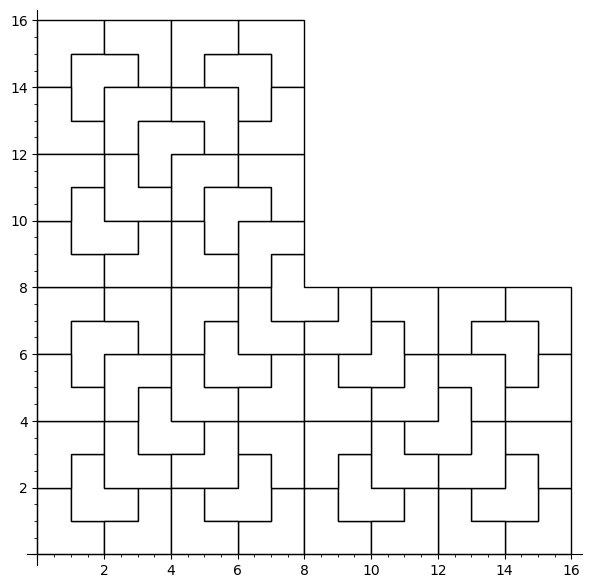

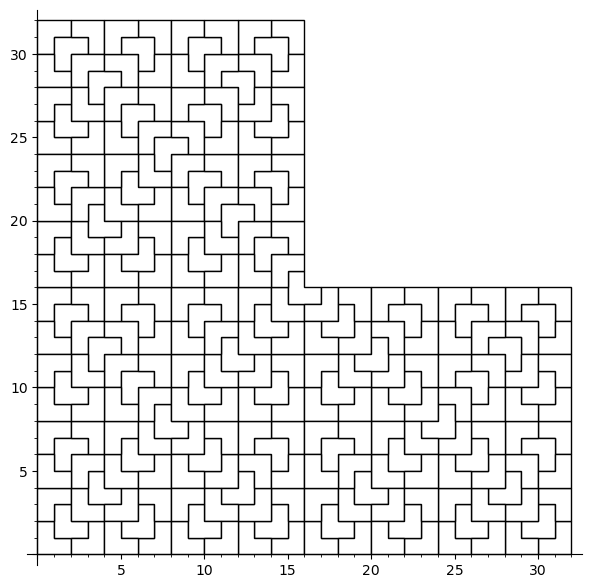

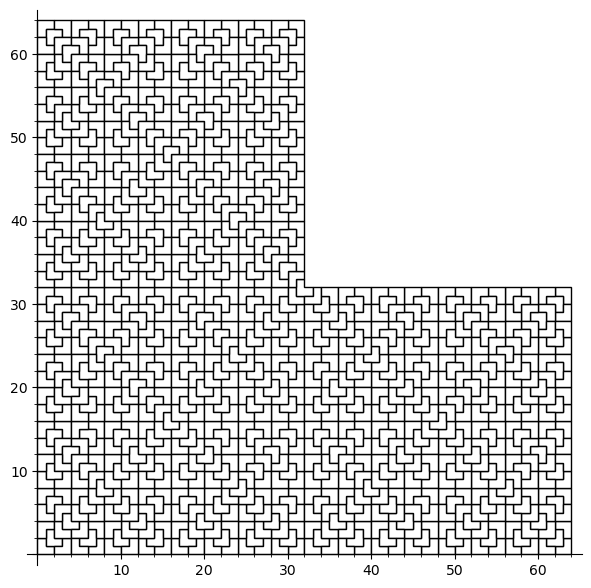

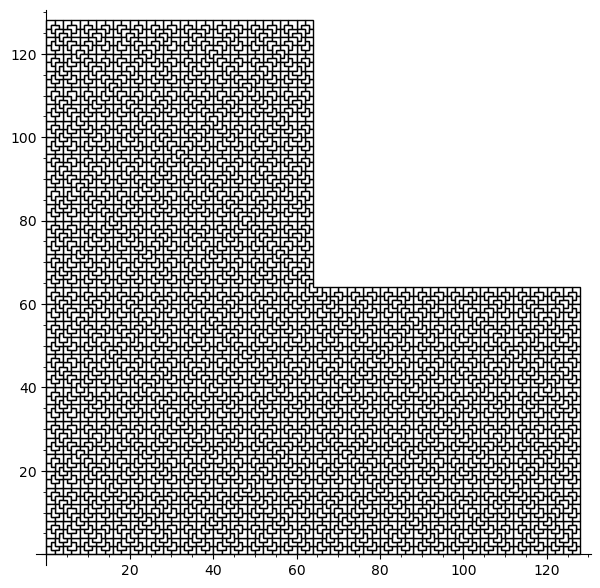

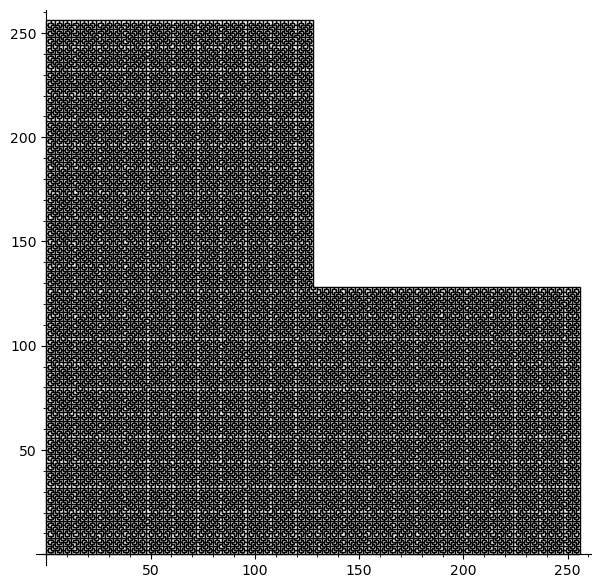

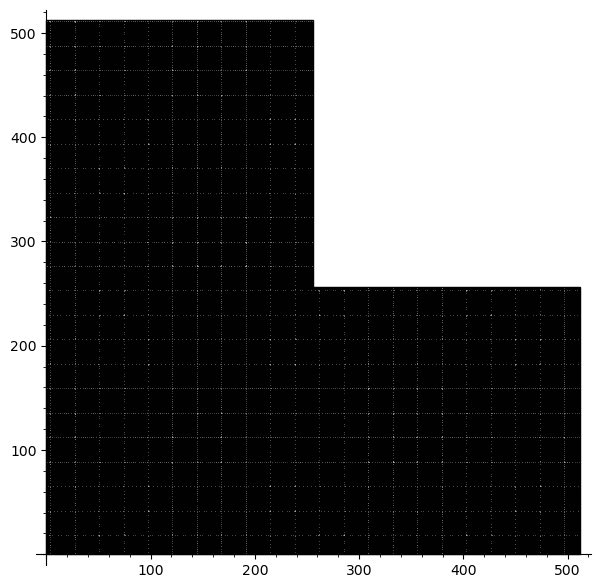

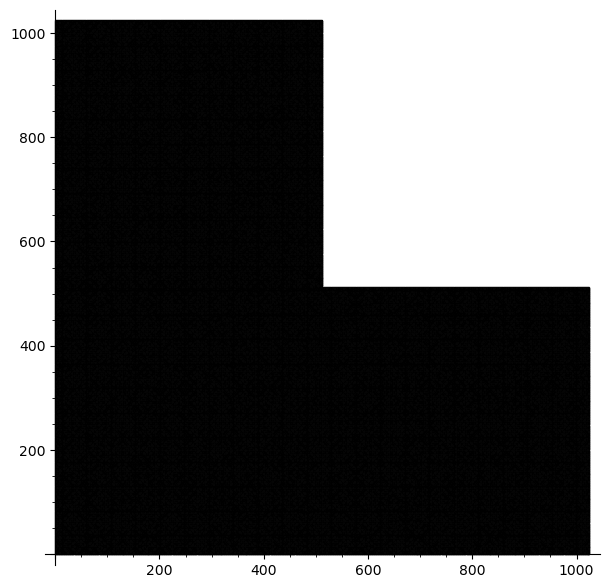

In [4]:
Ln = construct_chair_tiling(10)
Ln

In [66]:
"""
There are two problems we want to solve:
1) How large of a supertile must we compute to find all of the 1-collared prototiles?
2) How can we generate all of the 1-collared prototiles from a large enough subsection of the tiling?

Also, we want to be able to do this for other types of tilings, not just those that use vertical/horizontal
lines to construct the prototiles. For instance, https://tilings.math.uni-bielefeld.de/substitution/binary/
uses rhombuses with internal angles either in {pi/5, 3pi/5} or {2pi/5, 4pi/5}

For now, the focus will be on representing tilings as a collection of objects rather than as a graphics
object, as this will save computing power and the resulting collections can just be graphed after being
generated. Once we can generate large supertile objects, we can start to write functions that generate
the possible collars of a set of prototiles.
"""

class ChairTile:
    
    # We define a supertile by:
    # level, i.e. n where the supertile is L_n
    # orientation as a multiple of pi describing rotation around its center
    # origin, describing where to place this tile when moving up a level. The origin is the point that stays fixed
    #     when moving up a level.
    def __init__(self, level: int, orientation: RR, origin: vector):
        self.points = []
        self.level = level
        self.orientation = orientation
        self.origin = origin

        if (level < 0):
            raise Exception("Level must be a non-negative integer.")
        
        if (level == 0):
            self.points = [vector((0 + origin[0], 0 + origin[1])), 
                           vector((2 + origin[0], 0 + origin[1])), 
                           vector((2 + origin[0], 1 + origin[1])), 
                           vector((1 + origin[0], 1 + origin[1])), 
                           vector((1 + origin[0], 2 + origin[1])), 
                           vector((0 + origin[0], 2 + origin[1]))]
            self.center = [1 + origin[0], 1 + origin[1]]
            self.rotate_tile(self.center, self.orientation)

        else:
            # If this is a supertile, we consider it to be the collection of all the prototiles that make it up
            self.subtiles = list()
            st_1 = ChairTile(level - 1, 0, origin)
            st_2 = ChairTile(level - 1, 0, origin + vector((2**(level - 1), 2**(level - 1))))
            st_3 = ChairTile(level - 1, pi/2, origin + vector ((2** (level + 1), 0)))
            st_4 = ChairTile(level - 1, 3*pi/2, origin + vector((0, 2** (level + 1))))
            self.subtiles.append(st_1)
            self.subtiles.append(st_2)
            self.subtiles.append(st_3)
            self.subtiles.append(st_4)

        

    # Rotates a tile around center by theta degrees, clockwise
    def rotate_tile(self, center, theta):
        if (theta == 0):
            return
        R = matrix(2,2,[cos(theta),-sin(theta),sin(theta),cos(theta)])
        pts = [R*vector((self.points[i][0]-center[0],self.points[i][1]-center[1])) for i in range(len(self.points))]
        self.points = [(pts[i][0]+center[0],pts[i][1]+center[1]) for i in range(len(self.points))]
        

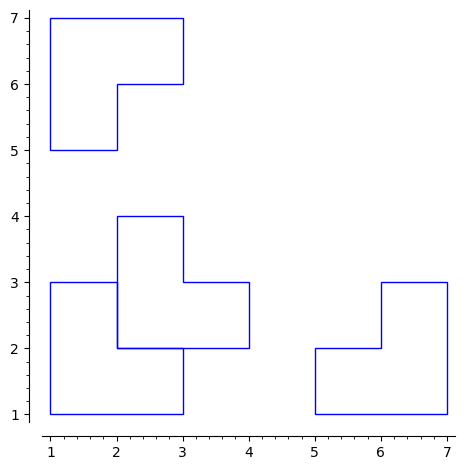

In [70]:
p = ChairTile(1, pi/4, vector((1,1)))
P = Graphics()
for s in p.subtiles:
    P += polygon(s.points, fill=false)

show(P)

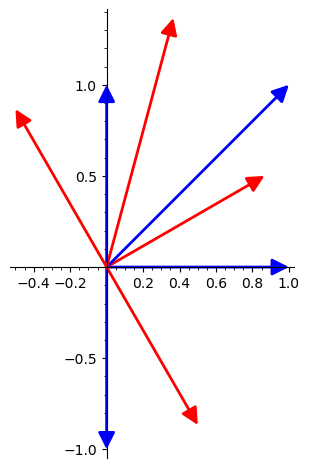

In [8]:
O = vector((0, 0))
Tp = vector((1, 0))
Np = vector((0, 1))

scene = [[Tp,Np],[Tp+Np,-Np]]

alpha = pi/6
R = matrix(2,2,[cos(alpha),-sin(alpha),sin(alpha),cos(alpha)])

p = Graphics()
for obj in scene:
    p += sum([plot(v) for v in obj])
    p += sum([plot(R*v,color='red') for v in obj])

p.show(aspect_ratio=1)